In [1]:
import random
from datasets import load_dataset
from transformers import AutoProcessor, VisionEncoderDecoderModel, AutoTokenizer
from PIL import Image
# from datasets import Dataset
import torch
from torch.utils.tensorboard import SummaryWriter

dataset_name='sylvain471/ordonnances-typewriter-3'
model_name='sylvain471/troc-archives-fr-XVIII'
# model_name='microsoft/trocr-base-handwritten'


dataset = load_dataset(dataset_name)


# Load model and processor
model = VisionEncoderDecoderModel.from_pretrained(model_name)
processor = AutoProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length=32
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
# model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.eos_token_id = processor.tokenizer.eos_token_id
# model.config.forced_eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = max_length
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4


/home/sylvain/Documents/training/Commanderie/trocr/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise y

In [ ]:
from peft import LoraConfig, get_peft_model


# layers=["q_proj","v_proj","k_proj","out_proj"]
# decoder_all_linear=["q_proj","v_proj","k_proj","out_proj","fc1","fc2"]
all_linear=["query","key","value",",dense","q_proj","v_proj","k_proj","out_proj","fc1","fc2"]


lora_config = LoraConfig(
    r=32,  # Low-rank dimension
    lora_alpha=64,  # Scaling factor
    # target_modules=["q_proj","k_proj"],  # Apply LoRA to decoder layers
    target_modules=all_linear,  # Apply LoRA to decoder layers
    lora_dropout=0.1,  # Dropout for regularization
    bias="none"  # No bias added
)
model = get_peft_model(model, lora_config)

In [4]:
model

PeftModel(
  (base_model): LoraModel(
    (model): VisionEncoderDecoderModel(
      (encoder): ViTModel(
        (embeddings): ViTEmbeddings(
          (patch_embeddings): ViTPatchEmbeddings(
            (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
          )
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): ViTEncoder(
          (layer): ModuleList(
            (0-11): 12 x ViTLayer(
              (attention): ViTAttention(
                (attention): ViTSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=32, bias=False)
                    )
                    (lora_B): ModuleDict(
                 

In [5]:
import torch
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from evaluate import load
from torch.utils.data import Dataset



class IMCDataset(Dataset):
    def __init__(self, ds, processor, max_target_length=32):
        self.ds = ds
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        text = self.ds[idx]['text']
        image = self.ds[idx]['image'].convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(text, 
                                          padding="max_length",
                                          truncation=True, 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding
    
cer = load("cer")

def compute_metrics(pred):
    global cer
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer_score = cer.compute(predictions=pred_str, references=label_str)
    print("CER:",cer_score)
    return {"cer": cer_score}

train_ds=dataset['train']
train_dataset = IMCDataset(ds=train_ds,processor=processor)

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    # evaluation_strategy="steps",
    num_train_epochs=10,  
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    # fp16=True, 
    bf16=True,
    output_dir="./trocr-ordonnances-malte",
    logging_steps=10,
    save_steps=1500,
    # eval_steps=100,
    report_to='tensorboard',
    gradient_accumulation_steps=4
    # resume_from_checkpoint="./catmus/checkpoint-2000"
)

In [6]:
nb_params=0
for name, param in model.named_parameters():
    if param.requires_grad:
        # print(name, param.requires_grad, param.size()[0]*param.size()[1])
        nb_params+=param.size()[0]*param.size()[1]
print('Nb params:',nb_params)

Nb params: 11796480


In [7]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    # eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

trainer.train()

/home/sylvain/Documents/training/Commanderie/trocr/.venv/lib/python3.11/site-packages/transformers/models/trocr/processing_trocr.py:137: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
  2%|▏         | 10/530 [00:27<23:31,  2.72s/it]

{'loss': 1.625, 'grad_norm': 1.4173763990402222, 'learning_rate': 4.9056603773584906e-05, 'epoch': 0.19}


  4%|▍         | 20/530 [00:54<23:18,  2.74s/it]

{'loss': 1.5552, 'grad_norm': 1.1863114833831787, 'learning_rate': 4.811320754716982e-05, 'epoch': 0.37}


  6%|▌         | 30/530 [01:22<23:05,  2.77s/it]

{'loss': 1.2268, 'grad_norm': 1.2143583297729492, 'learning_rate': 4.716981132075472e-05, 'epoch': 0.56}


  8%|▊         | 40/530 [01:50<22:29,  2.75s/it]

{'loss': 1.2732, 'grad_norm': 1.2243632078170776, 'learning_rate': 4.6226415094339625e-05, 'epoch': 0.75}


  9%|▉         | 50/530 [02:18<22:10,  2.77s/it]

{'loss': 1.0514, 'grad_norm': 1.3910990953445435, 'learning_rate': 4.528301886792453e-05, 'epoch': 0.93}


 11%|█▏        | 60/530 [02:45<21:43,  2.77s/it]

{'loss': 0.8831, 'grad_norm': 1.7932826280593872, 'learning_rate': 4.433962264150944e-05, 'epoch': 1.12}


 13%|█▎        | 70/530 [03:14<21:34,  2.81s/it]

{'loss': 0.8907, 'grad_norm': 1.4289110898971558, 'learning_rate': 4.3396226415094345e-05, 'epoch': 1.31}


 15%|█▌        | 80/530 [03:42<21:01,  2.80s/it]

{'loss': 0.8034, 'grad_norm': 1.2519346475601196, 'learning_rate': 4.245283018867925e-05, 'epoch': 1.5}


 17%|█▋        | 90/530 [04:10<20:43,  2.83s/it]

{'loss': 0.7768, 'grad_norm': 2.194007396697998, 'learning_rate': 4.150943396226415e-05, 'epoch': 1.68}


 19%|█▉        | 100/530 [04:38<20:25,  2.85s/it]

{'loss': 0.7117, 'grad_norm': 1.2767072916030884, 'learning_rate': 4.0566037735849064e-05, 'epoch': 1.87}


 21%|██        | 110/530 [05:07<19:55,  2.85s/it]

{'loss': 0.7125, 'grad_norm': 1.3233885765075684, 'learning_rate': 3.962264150943397e-05, 'epoch': 2.06}


 23%|██▎       | 120/530 [05:35<19:40,  2.88s/it]

{'loss': 0.6388, 'grad_norm': 1.2000066041946411, 'learning_rate': 3.867924528301887e-05, 'epoch': 2.24}


 25%|██▍       | 130/530 [06:04<19:13,  2.88s/it]

{'loss': 0.5978, 'grad_norm': 1.2834813594818115, 'learning_rate': 3.7735849056603776e-05, 'epoch': 2.43}


 26%|██▋       | 140/530 [06:33<18:47,  2.89s/it]

{'loss': 0.6169, 'grad_norm': 1.1549909114837646, 'learning_rate': 3.679245283018868e-05, 'epoch': 2.62}


 28%|██▊       | 150/530 [07:02<18:21,  2.90s/it]

{'loss': 0.5363, 'grad_norm': 1.338531732559204, 'learning_rate': 3.5849056603773584e-05, 'epoch': 2.8}


 30%|███       | 160/530 [07:31<17:54,  2.90s/it]

{'loss': 0.5535, 'grad_norm': 1.089944839477539, 'learning_rate': 3.490566037735849e-05, 'epoch': 2.99}


 32%|███▏      | 170/530 [08:00<17:24,  2.90s/it]

{'loss': 0.4799, 'grad_norm': 1.2349669933319092, 'learning_rate': 3.39622641509434e-05, 'epoch': 3.18}


 34%|███▍      | 180/530 [08:29<16:45,  2.87s/it]

{'loss': 0.4775, 'grad_norm': 1.089538812637329, 'learning_rate': 3.30188679245283e-05, 'epoch': 3.36}


 36%|███▌      | 190/530 [08:58<16:08,  2.85s/it]

{'loss': 0.5025, 'grad_norm': 1.127035140991211, 'learning_rate': 3.207547169811321e-05, 'epoch': 3.55}


 38%|███▊      | 200/530 [09:26<15:39,  2.85s/it]

{'loss': 0.4835, 'grad_norm': 1.2038275003433228, 'learning_rate': 3.113207547169811e-05, 'epoch': 3.74}


 40%|███▉      | 210/530 [09:55<15:10,  2.85s/it]

{'loss': 0.4881, 'grad_norm': 1.356157660484314, 'learning_rate': 3.018867924528302e-05, 'epoch': 3.93}


 42%|████▏     | 220/530 [10:23<14:40,  2.84s/it]

{'loss': 0.4003, 'grad_norm': 1.1469773054122925, 'learning_rate': 2.9245283018867926e-05, 'epoch': 4.11}


 43%|████▎     | 230/530 [10:51<14:14,  2.85s/it]

{'loss': 0.4219, 'grad_norm': 1.298709511756897, 'learning_rate': 2.830188679245283e-05, 'epoch': 4.3}


 45%|████▌     | 240/530 [11:20<13:46,  2.85s/it]

{'loss': 0.3912, 'grad_norm': 1.2278672456741333, 'learning_rate': 2.7358490566037738e-05, 'epoch': 4.49}


 47%|████▋     | 250/530 [11:48<13:14,  2.84s/it]

{'loss': 0.4331, 'grad_norm': 1.1178369522094727, 'learning_rate': 2.641509433962264e-05, 'epoch': 4.67}


 49%|████▉     | 260/530 [12:17<12:46,  2.84s/it]

{'loss': 0.4313, 'grad_norm': 1.1570162773132324, 'learning_rate': 2.547169811320755e-05, 'epoch': 4.86}


 51%|█████     | 270/530 [12:45<12:08,  2.80s/it]

{'loss': 0.4027, 'grad_norm': 1.147254228591919, 'learning_rate': 2.4528301886792453e-05, 'epoch': 5.05}


 53%|█████▎    | 280/530 [13:13<11:50,  2.84s/it]

{'loss': 0.3564, 'grad_norm': 1.1716464757919312, 'learning_rate': 2.358490566037736e-05, 'epoch': 5.23}


 55%|█████▍    | 290/530 [13:42<11:22,  2.85s/it]

{'loss': 0.3951, 'grad_norm': 1.4150928258895874, 'learning_rate': 2.2641509433962265e-05, 'epoch': 5.42}


 57%|█████▋    | 300/530 [14:10<10:52,  2.84s/it]

{'loss': 0.3506, 'grad_norm': 1.0440523624420166, 'learning_rate': 2.1698113207547172e-05, 'epoch': 5.61}


 58%|█████▊    | 310/530 [14:39<10:25,  2.84s/it]

{'loss': 0.3403, 'grad_norm': 1.0943883657455444, 'learning_rate': 2.0754716981132076e-05, 'epoch': 5.79}


 60%|██████    | 320/530 [15:07<09:54,  2.83s/it]

{'loss': 0.3665, 'grad_norm': 1.14211905002594, 'learning_rate': 1.9811320754716984e-05, 'epoch': 5.98}


 62%|██████▏   | 330/530 [15:35<09:28,  2.84s/it]

{'loss': 0.3606, 'grad_norm': 0.9396492838859558, 'learning_rate': 1.8867924528301888e-05, 'epoch': 6.17}


 64%|██████▍   | 340/530 [16:04<08:59,  2.84s/it]

{'loss': 0.3379, 'grad_norm': 1.0385738611221313, 'learning_rate': 1.7924528301886792e-05, 'epoch': 6.36}


 66%|██████▌   | 350/530 [16:32<08:31,  2.84s/it]

{'loss': 0.3385, 'grad_norm': 1.1699820756912231, 'learning_rate': 1.69811320754717e-05, 'epoch': 6.54}


 68%|██████▊   | 360/530 [17:01<08:11,  2.89s/it]

{'loss': 0.3265, 'grad_norm': 0.9346078038215637, 'learning_rate': 1.6037735849056604e-05, 'epoch': 6.73}


 70%|██████▉   | 370/530 [17:30<07:48,  2.93s/it]

{'loss': 0.3424, 'grad_norm': 1.0169862508773804, 'learning_rate': 1.509433962264151e-05, 'epoch': 6.92}


 72%|███████▏  | 380/530 [17:59<07:13,  2.89s/it]

{'loss': 0.2907, 'grad_norm': 0.9179896712303162, 'learning_rate': 1.4150943396226415e-05, 'epoch': 7.1}


 74%|███████▎  | 390/530 [18:28<06:45,  2.90s/it]

{'loss': 0.3103, 'grad_norm': 0.9619503617286682, 'learning_rate': 1.320754716981132e-05, 'epoch': 7.29}


 75%|███████▌  | 400/530 [18:57<06:17,  2.91s/it]

{'loss': 0.3164, 'grad_norm': 1.3432238101959229, 'learning_rate': 1.2264150943396227e-05, 'epoch': 7.48}


 77%|███████▋  | 410/530 [19:26<05:49,  2.91s/it]

{'loss': 0.3079, 'grad_norm': 0.9104380011558533, 'learning_rate': 1.1320754716981132e-05, 'epoch': 7.66}


 79%|███████▉  | 420/530 [19:56<05:23,  2.94s/it]

{'loss': 0.3233, 'grad_norm': 1.0574711561203003, 'learning_rate': 1.0377358490566038e-05, 'epoch': 7.85}


 81%|████████  | 430/530 [20:25<04:50,  2.90s/it]

{'loss': 0.3226, 'grad_norm': 1.2431232929229736, 'learning_rate': 9.433962264150944e-06, 'epoch': 8.04}


 83%|████████▎ | 440/530 [20:54<04:22,  2.92s/it]

{'loss': 0.3111, 'grad_norm': 1.002252221107483, 'learning_rate': 8.49056603773585e-06, 'epoch': 8.22}


 85%|████████▍ | 450/530 [21:23<03:53,  2.92s/it]

{'loss': 0.2863, 'grad_norm': 1.1218048334121704, 'learning_rate': 7.547169811320755e-06, 'epoch': 8.41}


 87%|████████▋ | 460/530 [21:52<03:24,  2.92s/it]

{'loss': 0.2924, 'grad_norm': 0.8858157396316528, 'learning_rate': 6.60377358490566e-06, 'epoch': 8.6}


 89%|████████▊ | 470/530 [22:22<02:55,  2.92s/it]

{'loss': 0.3026, 'grad_norm': 1.140678882598877, 'learning_rate': 5.660377358490566e-06, 'epoch': 8.79}


 91%|█████████ | 480/530 [22:51<02:25,  2.92s/it]

{'loss': 0.2923, 'grad_norm': 1.0285776853561401, 'learning_rate': 4.716981132075472e-06, 'epoch': 8.97}


 92%|█████████▏| 490/530 [23:20<01:56,  2.91s/it]

{'loss': 0.2792, 'grad_norm': 1.0833839178085327, 'learning_rate': 3.7735849056603773e-06, 'epoch': 9.16}


 94%|█████████▍| 500/530 [23:49<01:27,  2.92s/it]

{'loss': 0.3237, 'grad_norm': 1.0830892324447632, 'learning_rate': 2.830188679245283e-06, 'epoch': 9.35}


 96%|█████████▌| 510/530 [24:18<00:58,  2.92s/it]

{'loss': 0.3078, 'grad_norm': 1.4239177703857422, 'learning_rate': 1.8867924528301887e-06, 'epoch': 9.53}


 98%|█████████▊| 520/530 [24:48<00:29,  2.93s/it]

{'loss': 0.2922, 'grad_norm': 1.6362260580062866, 'learning_rate': 9.433962264150943e-07, 'epoch': 9.72}


100%|██████████| 530/530 [25:17<00:00,  2.92s/it]

{'loss': 0.2641, 'grad_norm': 1.130536437034607, 'learning_rate': 0.0, 'epoch': 9.91}


100%|██████████| 530/530 [25:18<00:00,  2.86s/it]

{'train_runtime': 1518.2968, 'train_samples_per_second': 22.512, 'train_steps_per_second': 0.349, 'train_loss': 0.5226934833346673, 'epoch': 9.91}


TrainOutput(global_step=530, training_loss=0.5226934833346673, metrics={'train_runtime': 1518.2968, 'train_samples_per_second': 22.512, 'train_steps_per_second': 0.349, 'total_flos': 3.102822434431461e+19, 'train_loss': 0.5226934833346673, 'epoch': 9.906542056074766})

HORSTUGAC, du couchant et du Nord avec les terres de ladite dame. allée et


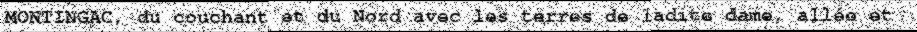

In [10]:

i=1200
image = train_ds[i]["image"].convert('RGB')
pixel_values = (processor(images=image, return_tensors="pt").pixel_values)
generated_ids = model.generate(pixel_values.to("cuda"))
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)
image

In [ ]:
from transformers import TrOCRProcessor,AutoTokenizer
from transformers import VisionEncoderDecoderModel

# processor = TrOCRProcessor.from_pretrained("trocr_inventaire_malte/checkpoint-105")
# processor = TrOCRProcessor.from_pretrained("sylvain471/troc-archives-fr-XVIII")
# model = VisionEncoderDecoderModel.from_pretrained("trocr-ordonnances-malte/checkpoint-530")
# tokenizer = AutoTokenizer.from_pretrained("sylvain471/troc-archives-fr-XVIII")

from dotenv import load_dotenv
import os
# Load environment variables from .env file
load_dotenv()
token=os.getenv("HF_TOKEN")

model.push_to_hub("sylvain471/trocr-ordonnances-malte",token=token)
processor.push_to_hub("sylvain471/trocr-ordonnances-malte",token=token)
tokenizer.push_to_hub("sylvain471/trocr-ordonnances-malte",token=token)